Load, inspect and clean the data. Split the data into a training set and a validation set and a test set. Use a simple classifier as a baseline. Train various classifiers. Motivate your choice in relation to the characteristics of the dataset. Try to combine them into an ensemble learning model that outperforms all of the others. Please see the attached excel-file for the specific grading matrix.

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn import linear_model
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import sklearn.metrics as metrics
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import svm
from sklearn.metrics import classification_report
from sklearn.svm import SVC

from prediction.random_forest import random_forest
from prediction.decision_tree import decision_tree

## 1. Read and inspect the data

In [2]:
df = pd.read_csv('parkinsons.data')
df

,name,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,...,Shimmer:DDA,NHR,HNR,status,RPDE,DFA,spread1,spread2,D2,PPE
0,phon_R01_S01_1,119.992,157.302,74.997,0.00784,0.00007,0.00370,0.00554,0.01109,0.04374,...,0.06545,0.02211,21.033,1,0.414783,0.815285,-4.813031,0.266482,2.301442,0.284654
1,phon_R01_S01_2,122.400,148.650,113.819,0.00968,0.00008,0.00465,0.00696,0.01394,0.06134,...,0.09403,0.01929,19.085,1,0.458359,0.819521,-4.075192,0.335590,2.486855,0.368674
2,phon_R01_S01_3,116.682,131.111,111.555,0.01050,0.00009,0.00544,0.00781,0.01633,0.05233,...,0.08270,0.01309,20.651,1,0.429895,0.825288,-4.443179,0.311173,2.342259,0.332634
3,phon_R01_S01_4,116.676,137.871,111.366,0.00997,0.00009,0.00502,0.00698,0.01505,0.05492,...,0.08771,0.01353,20.644,1,0.434969,0.819235,-4.117501,0.334147,2.405554,0.368975
4,phon_R01_S01_5,116.014,141.781,110.655,0.01284,0.00011,0.00655,0.00908,0.01966,0.06425,...,0.10470,0.01767,19.649,1,0.417356,0.823484,-3.747787,0.234513,2.332180,0.410335
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
190,phon_R01_S50_2,174.188,230.978,94.261,0.00459,0.00003,0.00263,0.00259,0.00790,0.04087,...,0.07008,0.02764,19.517,0,0.448439,0.657899,-6.538586,0.121952,2.657476,0.133050
191,phon_R01_S50_3,209.516,253.017,89.488,0.00564,0.00003,0.00331,0.00292,0.00994,0.02751,...,0.04812,0.01810,19.147,0,0.431674,0.683244,-6.195325,0.129303,2.784312,0.168895
192,phon_R01_S50_4,174.688,240.005,74.287,0.01360,0.00008,0.00624,0.00564,0.01873,0.02308,...,0.03804,0.10715,17.883,0,0.407567,0.655683,-6.787197,0.158453,2.679772,0.131728
193,phon_R01_S50_5,198.764,396.961,74.904,0.00740,0.00004,0.00370,0.00390,0.01109,0.02296,...,0.03794,0.07223,19.020,0,0.451221,0.643956,-6.744577,0.207454,2.138608,0.123306


In [3]:
df.describe()

,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,MDVP:Shimmer(dB),...,Shimmer:DDA,NHR,HNR,status,RPDE,DFA,spread1,spread2,D2,PPE
count,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,...,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000
mean,154.228641,197.104918,116.324631,0.006220,0.000044,0.003306,0.003446,0.009920,0.029709,0.282251,...,0.046993,0.024847,21.885974,0.753846,0.498536,0.718099,-5.684397,0.226510,2.381826,0.206552
std,41.390065,91.491548,43.521413,0.004848,0.000035,0.002968,0.002759,0.008903,0.018857,0.194877,...,0.030459,0.040418,4.425764,0.431878,0.103942,0.055336,1.090208,0.083406,0.382799,0.090119
min,88.333000,102.145000,65.476000,0.001680,0.000007,0.000680,0.000920,0.002040,0.009540,0.085000,...,0.013640,0.000650,8.441000,0.000000,0.256570,0.574282,-7.964984,0.006274,1.423287,0.044539
25%,117.572000,134.862500,84.291000,0.003460,0.000020,0.001660,0.001860,0.004985,0.016505,0.148500,...,0.024735,0.005925,19.198000,1.000000,0.421306,0.674758,-6.450096,0.174351,2.099125,0.137451
50%,148.790000,175.829000,104.315000,0.004940,0.000030,0.002500,0.002690,0.007490,0.022970,0.221000,...,0.038360,0.011660,22.085000,1.000000,0.495954,0.722254,-5.720868,0.218885,2.361532,0.194052
75%,182.769000,224.205500,140.018500,0.007365,0.000060,0.003835,0.003955,0.011505,0.037885,0.350000,...,0.060795,0.025640,25.075500,1.000000,0.587562,0.761881,-5.046192,0.279234,2.636456,0.252980
max,260.105000,592.030000,239.170000,0.033160,0.000260,0.021440,0.019580,0.064330,0.119080,1.302000,...,0.169420,0.314820,33.047000,1.000000,0.685151,0.825288,-2.434031,0.450493,3.671155,0.527367


In [4]:
## Exploratory plots:

## 2. Data preparation

In [5]:
## Move target column to end:
df = df[[c for c in df if c not in ['status']] + ['status']]

In [6]:
# Define target: status column
y= df['status']
# Define predictors: the measurements
X = df.iloc[:,1:-1]

The data consists of different units so scaling is appropiate.

In [7]:
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

In [8]:
def pcr(n_components):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    # Perform the PCA
    pca = PCA(n_components=n_components)
    X_train_transformed = pca.fit_transform(X_train)
    X_test_transformed = pca.transform(X_test)

    classifier = RandomForestClassifier(max_depth=2, random_state=0)
    classifier.fit(X_train_transformed, y_train)

    # Predicting the results of the test set
    y_pred = classifier.predict(X_test_transformed)
    
    return accuracy_score(y_test, y_pred)

accuracy_scores = []
for i in range(1,X.shape[1]):
    accuracy_scores.append(pcr(i))

In [9]:
print(accuracy_scores)

[0.7966101694915254, 0.8983050847457628, 0.8135593220338984, 0.9152542372881356, 0.8983050847457628, 0.8135593220338984, 0.864406779661017, 0.7966101694915254, 0.8983050847457628, 0.8305084745762712, 0.8305084745762712, 0.8813559322033898, 0.8813559322033898, 0.8813559322033898, 0.6949152542372882, 0.8983050847457628, 0.7966101694915254, 0.8135593220338984, 0.8813559322033898, 0.9152542372881356, 0.8305084745762712]


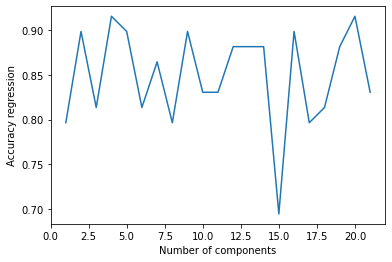

In [10]:
plt.plot(range(1,len(accuracy_scores)+1), accuracy_scores)
plt.xlabel('Number of components')
plt.ylabel('Accuracy regression')
plt.show();

## 3. Machine learning techniques
We want to distinguish between parkinson patients and non parkinson patients. This leads us to classification techniques. 

In [11]:
# Splitting the dataset into the Training set and Test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### 3.1 Randomforest

In [12]:
# Create base model:
rf_clf = RandomForestClassifier(random_state=42)
rf_clf.fit(X_train, y_train)
# Predicting the results of the test set
y_pred = rf_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.9322033898305084

The base model already has a high accuracy. Let's do some parameter tuning:

In [13]:
from sklearn.model_selection import RandomizedSearchCV
from pprint import pprint
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 100, num = 10)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


In [14]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [15]:
rf_random.best_params_

{'n_estimators': 2000,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 70,
 'bootstrap': True}

Let's compare baseline vs tuned model:

In [16]:
base_model = RandomForestClassifier(random_state = 42)
base_model.fit(X_train, y_train)
y_pred = base_model.predict(X_test)
accuracy_score(y_test, y_pred)

0.9322033898305084

In [17]:
rf_clf = rf_random.best_estimator_
y_pred = rf_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.9322033898305084

Random search allows narrowing down the range for hyperparameters. Using GridSearchCV, all combinations can be tried for further accuracy improvement.

In [18]:
# from sklearn.model_selection import GridSearchCV
# # Create the parameter grid based on the results of random search (rf_random.best_params_)
# param_grid = {
#     'bootstrap': [False],
#     'max_depth': [42, 46, 50, 54],
#     'max_features': ['auto'],
#     'min_samples_leaf': [1,2,3],
#     'min_samples_split': [1,2,3],
#     'n_estimators': [900,1000,1100,1200]
# }
# # Create a based model
# rf = RandomForestClassifier()
# # Instantiate the grid search model
# grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
#                           cv = 3, n_jobs = -1, verbose = 2)

In [19]:
# # Fit the grid search to the data
# grid_search.fit(X_train, y_train)

# grid_search.best_params_

# best_grid = grid_search.best_estimator_
# y_pred = best_grid.predict(X_test)
# accuracy_score(y_test, y_pred)

The model did not improve its accuracy using grid search. It is probably not a good use of time to try to improve the hyperparameters this way.

In [20]:
# Evaluate run time and prediction accuracy
import time
def evaluate_model(model, x_train, y_train, x_test, y_test):
    n_trees = model.get_params()['n_estimators']
    n_features = x_train.shape[1]
    
    # Train and predict 10 times to evaluate time and accuracy
    predictions = []
    run_times = []
    accuracy_scores = []
    for _ in range(10):
        start_time = time.time()
        model.fit(x_train, y_train)
        y_pred = model.predict(x_test)
        predictions.append(y_pred)
    
        end_time = time.time()
        run_times.append(end_time - start_time)
        accuracy_scores.append(accuracy_score(y_test, y_pred))
    
    # Run time and predictions need to be averaged
    run_time = np.mean(run_times)
    predictions = np.mean(np.array(predictions), axis = 0)
    
    # Calculate performance metrics
    errors = abs(predictions - y_test)
    mean_error = np.mean(errors)
    mean_accuracy = np.mean(accuracy_scores)
    
    # Return results in a dictionary
    results = {'time': run_time, 'error': mean_error, 'mean_accuracy': mean_accuracy, 'n_trees': n_trees, 'n_features': n_features}
    
    return results

In [22]:
best_random_results = evaluate_model(rf_clf, X_train, y_train, X_test, y_test)
best_random_results['model'] = 'best_random'

In [23]:
best_random_results

{'time': 2.464070272445679,
 'error': 0.06779661016949153,
 'mean_accuracy': 0.9322033898305084,
 'n_trees': 2000,
 'n_features': 22,
 'model': 'best_random'}

In [24]:
base_model = RandomForestClassifier()
base_model.fit(X_train, y_train)
base_model_results = evaluate_model(base_model, X_train, y_train, X_test, y_test)
base_model_results

{'time': 0.12789037227630615,
 'error': 0.06610169491525424,
 'mean_accuracy': 0.9338983050847457,
 'n_trees': 100,
 'n_features': 22}

Hyper parameter tuning did not improve the accuracy of the model in this case.

In [25]:
# predict_proba = rf_clf.predict_proba(X)
# predict_proba_df = pd.DataFrame(predict_proba, index=df['name'], columns = ['status 0 predicted', 'status 1 predicted'])
# print(classification_report(y_test, y_pred))

### 3.2 Support vector classifier

In [26]:
## kernels = {'linear', 'poly', 'rbf', 'sigmoid', 'precomputed'}
# Create base model:
svm_clf = SVC(random_state=42)
svm_clf.fit(X_train, y_train)
y_pred = svm_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.8813559322033898

In [27]:
from sklearn.model_selection import GridSearchCV
from pprint import pprint
# Kernels
kernels = ['linear', 'poly', 'rbf', 'sigmoid']
# C values
C_values = [0.1,1,5,10,20,40,49,50,51,60, 75, 100, 125, 150, 200, 1000]

# Create the random grid
param_grid = {'kernel': kernels,
               'C': C_values,}
pprint(param_grid)

{'C': [0.1, 1, 5, 10, 20, 40, 49, 50, 51, 60, 75, 100, 125, 150, 200, 1000],
 'kernel': ['linear', 'poly', 'rbf', 'sigmoid']}


In [28]:
svm_clf = SVC()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = svm_clf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

In [29]:
# Fit the grid search to the data
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 64 candidates, totalling 192 fits


GridSearchCV(cv=3, estimator=SVC(), n_jobs=-1,
             param_grid={'C': [0.1, 1, 5, 10, 20, 40, 49, 50, 51, 60, 75, 100,
                               125, 150, 200, 1000],
                         'kernel': ['linear', 'poly', 'rbf', 'sigmoid']},
             verbose=2)

In [30]:
grid_search.best_params_



{'C': 49, 'kernel': 'rbf'}

In [31]:
svc_clf = grid_search.best_estimator_
y_pred = svc_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.9491525423728814

### 3.3 Gradient boosting

In [32]:
from sklearn.ensemble import GradientBoostingClassifier
# Create base model:
gb_clf = GradientBoostingClassifier(random_state=42)
gb_clf.fit(X_train, y_train)
y_pred = gb_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.9152542372881356

In [33]:
from sklearn.model_selection import GridSearchCV
from pprint import pprint
# loss functions
loss = ['log_loss', 'deviance', 'exponential']
# learning rate
learning_rates = [0.01, 0.1, 0.2, 0.3, 1]
# n_estimators
n_estimators = [10,100,200,300]

# Create the random grid
param_grid = {'loss': loss,
               'learning_rate': learning_rates,
               'n_estimators': n_estimators}
pprint(param_grid)

{'learning_rate': [0.01, 0.1, 0.2, 0.3, 1],
 'loss': ['log_loss', 'deviance', 'exponential'],
 'n_estimators': [10, 100, 200, 300]}


In [34]:
gb_clf = GradientBoostingClassifier(random_state=42)
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = gb_clf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

In [35]:
# Fit the grid search to the data
grid_search.fit(X_train, y_train)


Fitting 3 folds for each of 60 candidates, totalling 180 fits


c:\Users\hendr\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan        nan 0.75732689 0.83832528
 0.86747182 0.8747182  0.75732689 0.83832528 0.88196457 0.86779388
        nan        nan        nan        nan 0.84573269 0.90450886
 0.91916264 0.88985507 0.84573269 0.90434783 0.91175523 0.88969404
        nan        nan        nan        nan 0.87487923 0.89710145
 0.88969404 0.89710145 0.81626409 0.87520129 0.88985507 0.87520129
        nan        nan        nan        nan 0.86006441 0.88985507
 0.88985507 0.89710145 0.87455717 0.87504026 0.89710145 0.89710145
        nan        nan        nan        nan 0.83832528 0.87520129
 0.88244767 0.87504026 0.8747182  0.88244767 0.88244767 0.88244767]
  warnings.warn(


GridSearchCV(cv=3, estimator=GradientBoostingClassifier(random_state=42),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 0.2, 0.3, 1],
                         'loss': ['log_loss', 'deviance', 'exponential'],
                         'n_estimators': [10, 100, 200, 300]},
             verbose=2)

In [36]:
grid_search.best_params_

{'learning_rate': 0.1, 'loss': 'deviance', 'n_estimators': 200}

In [37]:
gb_clf = grid_search.best_estimator_
y_pred = gb_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.9152542372881356

## 4. Ensemble learning

In [38]:
## RandomForestClassifier:
rf_clf
## SupportVectorClassifier:
svc_clf
## GradientBoostingClassifier:
gb_clf

GradientBoostingClassifier(n_estimators=200, random_state=42)

In [39]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

In [40]:
estimators = [('rf', rf_clf),
              ('svc', svc_clf),
              ('gb', gb_clf)]

clf = StackingClassifier(estimators=estimators, cv=None, final_estimator=LogisticRegression())

In [41]:
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.9322033898305084